<a href="https://colab.research.google.com/github/quent1fvr/Infection_pulmonaire/blob/Quentin/Infection_pulmonaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import keras#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/UV PROJET P6/COVID_dataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()


KeyboardInterrupt: ignored

In [ ]:
print(len(os.listdir('/tmp/COVID_crop/malade')))
print(len(os.listdir('/tmp/COVID_crop/normal')))
path ='/tmp/COVID_crop'

1544
1078


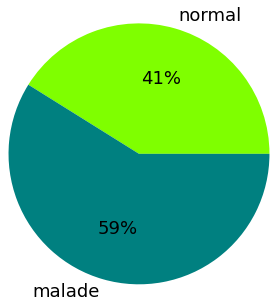

In [ ]:
path_malade = "/tmp/COVID_crop/malade"
path_normal = "/tmp/COVID_crop/normal"

x = np.array([len(os.listdir(path_normal)),len(os.listdir(path_malade))])
labels = ['normal', 'malade']
colors = {'normal': 'chartreuse','malade': 'teal' }
plt.pie(x, labels = labels, autopct = '%.0f%%', radius= 1.5, colors = [colors[key] for key in labels], textprops={'fontsize': 18})
plt.show()

Etude de la distribution des données

[18, 21, 21, 22, 22, 22, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 43, 43, 44, 44, 44, 44, 45, 45, 46, 48, 54, 54, 55, 55, 55, 55, 55, 56, 56, 56, 57, 57, 57, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66,

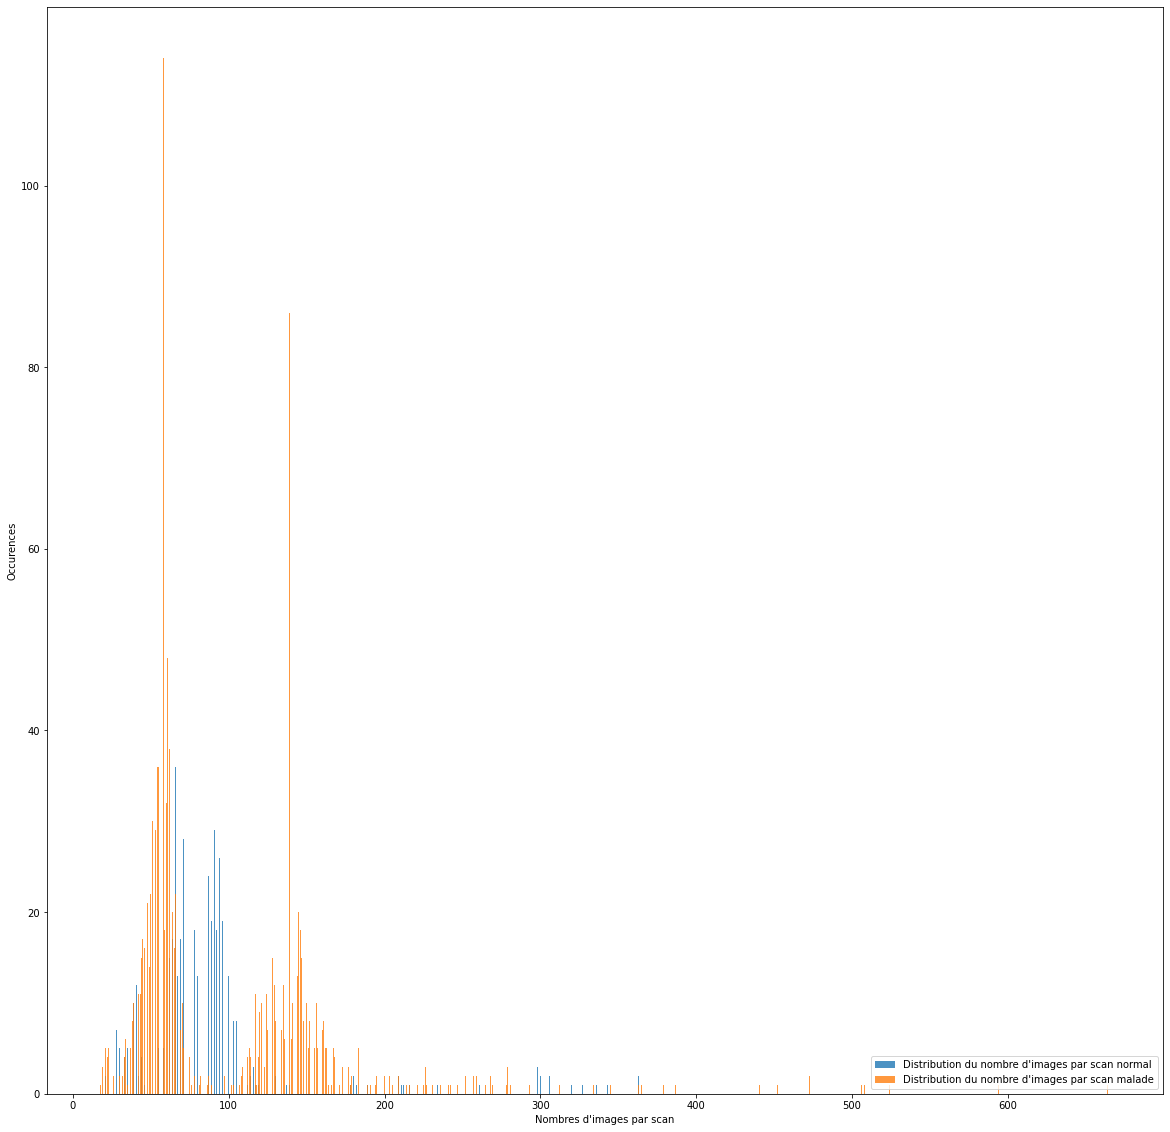

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))

tab_normal = []
tab_malade = []

dir_normal = '/tmp/COVID_crop/normal'
dir_malade = '/tmp/COVID_crop/malade'

for base in os.walk(dir_normal):
    #print('folder "', base[0], '" containing ', len(base[2]), ' files')
    tab_normal.append(len(base[2]))
tab_normal.pop(0)
tab_normal.sort()
print(tab_normal)

for base in os.walk(dir_malade):
    #print('folder "', base[0], '" containing ', len(base[2]), ' files')
    tab_malade.append(len(base[2]))
tab_malade.pop(0)
tab_malade.sort()
print(tab_malade)

x0 = tab_normal
x1 = tab_malade

bins = max(len(x0), len(x1))

plt.hist(x0, bins, alpha=0.8, label="Distribution du nombre d'images par scan normal")
plt.hist(x1, bins, alpha=0.8, label="Distribution du nombre d'images par scan malade")
plt.legend(loc='lower right')
plt.xlabel("Nombres d'images par scan")
plt.ylabel("Occurences")
plt.show()



In [ ]:
x0 = np.array(x0)
x1 = np.array(x1)

print(np.mean(x0))
print(np.mean(x1))


avg=(59*88.82745825602969+41*101)/100
avg


88.82745825602969
101.08225388601036


93.81820037105751

On pourrait éliminer les scans avec plus de 200 images
recalculer la moyenne et conserver ce nombre d'images moy